In [64]:
import os 
import sys 
sys.path.append('./src')
import pandas as pd 
import re
from occm import * 
from ncbi import download
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm 

DATA_DIR = os.path.abspath('./data')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
genome_ids = pd.read_csv('./data/genomes.csv', usecols=['accession']).values.ravel()
genome_ids = [genome_id.replace('GB_', '').replace('RS_', '') for genome_id in genome_ids]
download(genome_ids, path='./data/genomes/')

download_genomes:   0%|          | 0/196 [00:00<?, ?it/s]

download_genomes:  41%|████▏     | 81/196 [04:26<06:28,  3.38s/it]

In [26]:
# Download the latest GTDB bacteria metadata from the FTP site https://data.gtdb.ecogenomic.org/releases/latest/
gtdb_metadata_df = pd.read_csv(os.path.join(DATA_DIR, 'bac120_metadata_r220.tsv'), sep='\t')
print(len(gtdb_metadata_df), 'total genome entries in GTDB.')
# Filter for complete genomes. 
gtdb_metadata_df = gtdb_metadata_df[gtdb_metadata_df.ncbi_genome_representation == 'full']
print(len(gtdb_metadata_df), 'total complete genome entries in GTDB.')

584382 total genome entries in GTDB.
584319 total complete genome entries in GTDB.


In [33]:
# for col in gtdb_metadata_df.columns:
#     print(col)

In [30]:
def get_taxonomy(gtdb_metadata_df:pd.DataFrame, level:str='p'):
    '''Extract the taxonomy from the lineage string in the metadata.'''
    taxonomy = []
    for entry in gtdb_metadata_df.gtdb_taxonomy:
        match = re.search(f'{level}__([^;]+)', entry)
        if match is None:
            taxonomy.append(None)
        else:
            taxonomy.append(match.group(1))
    return taxonomy

In [31]:
gtdb_metadata_df['phylum'] = get_taxonomy(gtdb_metadata_df)
print(len(gtdb_metadata_df.phylum.unique()), 'unique phyla present in the data.')

196 unique phyla present in the data.


In [35]:
# Get the genomes with the highest checkm_completeness from each phylum. 
gtdb_metadata_df = gtdb_metadata_df.sort_values('checkm_completeness', ascending=False).groupby('phylum', as_index=False).first()

In [37]:
gtdb_metadata_df.set_index('accession').to_csv('./data/genomes.csv')

In [50]:
genome = Genome('./data/sequence.fn', read_size=200)
# B = len(genome)
# print(f'Genome contains {B} base pairs.')

Genome.__init__: Loaded 1 sequences from the FASTA file.


In [26]:
def get_max_contig_lengths(genome:Genome, read_depth:int=10000, n_samples:int=500):
    max_contig_lengths = []
    for _ in tqdm(range(n_samples), desc='get_max_contig_lengths'):
        genome.build_graphs(read_depth=read_depth)

        # # What is the average number of next nodes?
        # graph = genome.seqs[0].graph
        # avg_next = np.mean([len(read.next) for read in graph.reads.values()])
        # print('Average number of "next" nodes:', avg_next)

        contigs = genome.get_contigs()
        max_contig_lengths.append(max([len(contig) for contig in contigs]))

    return np.array(sorted(max_contig_lengths))

In [4]:
# The probability that the longest contig exceeds length k, or P(C >= k), is given by 
# 1 - exp(-beta**k (beta**(-thetaW) + beta**(-thetaT)))

# L is read length, B is genome length. 

# thetaT = log(1/beta)((B/L - 2)(1 - beta) + 1)
# thetaT = log(1/beta)((B/L - 1)(1 - beta) + 1)

# This should match the ECDF... 

In [17]:
print(len(genome))

4641652


In [53]:
coverages = []
for i in range(100):
    genome.build_graphs(read_depth=10000)
    contigs = genome.get_contigs()
    coverages.append(genome.seqs[0].get_coverage(contigs))
np.mean(coverages)

np.float64(0.31974004083029056)

In [63]:
coverages

[0.3168483979410779,
 0.3207263276092219,
 0.32102794436118864,
 0.31911052358082853,
 0.32040316680354325,
 0.32216977920791995,
 0.31954140465506675,
 0.31951986060135484,
 0.31816258521750446,
 0.32029544653498365,
 0.32001537383672884,
 0.3194121403327953,
 0.3179471446803853,
 0.3221051470467842,
 0.32137264922057923,
 0.3205108870721028,
 0.31926133195681194,
 0.3205755192332385,
 0.3190458914196928,
 0.32025235842755984,
 0.3215880897576983,
 0.3188089068288618,
 0.3201230941052884,
 0.31915361168825235,
 0.3189597152048452,
 0.31958449276249057,
 0.3187873627751499,
 0.31734391117645183,
 0.31835648170091163,
 0.31960603681620253,
 0.320209270320136,
 0.320209270320136,
 0.32044625491096707,
 0.31809795305636873,
 0.321674265972546,
 0.32109257652232437,
 0.31779633630440196,
 0.31923978790310004,
 0.3198430214070335,
 0.32040316680354325,
 0.3180117768415211,
 0.3201446381590003,
 0.32137264922057923,
 0.31958449276249057,
 0.3194552284402191,
 0.32216977920791995,
 0.31878736

Number of bins: 46415
Probability of at least one read occurring in any given bin: 0.3500759873747368


get_max_contig_lengths: 100%|██████████| 500/500 [01:04<00:00,  7.79it/s]

Biggest max contig length: 2800


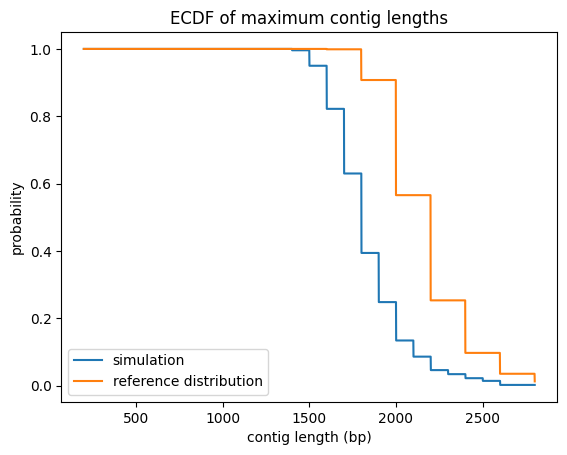

In [45]:
# Plot an ECDF of the maximum contig lengths from different attempts at reading the same genome. 
read_size = 200
read_depth = 20000 
alpha = genome.n_bins()
beta = 1 - (1 - 1 / alpha) ** read_depth # This is the probability of at least one read occurring in every bin. 
print('Number of bins:', alpha)
print('Probability of at least one read occurring in any given bin:', beta) # np.round(beta, 2))

max_contig_lengths = get_max_contig_lengths(genome, read_depth=read_depth, n_samples=500)
print('Biggest max contig length:', max(max_contig_lengths))

fig, ax = plt.subplots()

x_vals, y_vals = [], []
for l in np.arange(read_size, max(max_contig_lengths) + 1):
    x_vals.append(l)
    y_vals.append(np.mean(max_contig_lengths >= l))

y_vals_ref = [pcgtk(r=read_depth, k=x // read_size, b=len(genome), l=read_size) for x in x_vals]

# I think it would be better to put contig length in terms of number of reads, to mirror the paper. 
ax.plot(x_vals, y_vals)
ax.plot(x_vals, y_vals_ref)

ax.legend(['simulation', 'reference distribution'])
ax.set_xlabel('contig length (bp)')
ax.set_ylabel('probability')
ax.set_title('ECDF of maximum contig lengths')
plt.show()


In [41]:
x_vals

[]

In [45]:
y_vals

[0.6321205588285577,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 